In [19]:
import sys
import os
from pathlib import Path

src_path = Path.home() / "QuditEM" / "src"

src_path = src_path.resolve()
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

In [20]:
from qudit_ops.operators import *
from qudit_ops.pcs import get_counts,plot_histogram,postselection
from qudit_ops.pcs import hellinger_fidelity
import math
import cirq
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Applying PCS to ghz(2) circuit to detect errors and compare fidelity readings across different error rates

In [22]:
def noisy_pcs_ghz(dims: int,p: float, n_qudits: int = 2) -> cirq.Circuit:
    total_qids = n_qudits + 2
    qids = cirq.LineQid.range(total_qids, dimension=dims)

    z_rcheck = lambda : [circuit.append(CZGate(i,dims-i,dims).on(qids[2],qids[0])) for i in range(1,dims)]
    z_lcheck = lambda : [circuit.append(CZGate(i,i,dims).on(qids[2],qids[0])) for i in range(1,dims)]
    x_lcheck = lambda : [circuit.append(CModAdd(i,dims-i,dims).on(qids[3],qids[1])) for i in range(1,dims)]
    x_rcheck = lambda : [circuit.append(CModAdd(i,i,dims).on(qids[3],qids[1])) for i in range(1,dims)]
    error_moment = cirq.Moment(QuditDepolarizingChannel(p,dims).on_each(qids[0],qids[1]))
    circuit = cirq.Circuit()
    circuit.append(Christensen(dim=dims).on_each(qids[0],qids[2],qids[3]))
    z_lcheck()
    x_lcheck()
    for k in range(dims-1):
        circuit.append(CModAdd(k+1,k+1,dims).on(qids[0],qids[1]))
    circuit.append(error_moment)
    x_rcheck()
    z_rcheck()
    circuit.append(Christensen(dim=dims).on_each(qids[2],qids[3]))
    
    circuit.append(cirq.measure(*qids,key='a'))
    circ_sim = cirq.Simulator().run(circuit,repetitions=1024)
    circ_res = get_counts(circ_sim,'a')
    # print(circuit)
    ps_circ_res = postselection(circ_res,ancillas=2)
    return ps_circ_res

def pcs_ideal_ghz(dim: int):
    total_qids = 4
    qids = cirq.LineQid.range(total_qids, dimension=dim)

    z_rcheck = lambda : [circuit_pcs.append(CZGate(i,dim-i,dim).on(qids[2],qids[0])) for i in range(1,dim)]
    z_lcheck = lambda : [circuit_pcs.append(CZGate(i,i,dim).on(qids[2],qids[0])) for i in range(1,dim)]
    x_lcheck = lambda : [circuit_pcs.append(CModAdd(i,dim-i,dim).on(qids[3],qids[1])) for i in range(1,dim)]
    x_rcheck = lambda : [circuit_pcs.append(CModAdd(i,i,dim).on(qids[3],qids[1])) for i in range(1,dim)]
    
    circuit_pcs = cirq.Circuit()
    circuit_pcs.append(Christensen(dim=dim).on_each(qids[0],qids[2],qids[3]))
    z_lcheck()
    x_lcheck()
    for k in range(dim-1):
        circuit_pcs.append(CModAdd(k+1,k+1,dim).on(qids[0],qids[1]))
    x_rcheck()
    z_rcheck()
    circuit_pcs.append(Christensen(dim=dim).on_each(qids[2],qids[3]))
    circuit_pcs.append(cirq.measure(*qids,key='a'))
    circ_sim = cirq.Simulator().run(circuit_pcs,repetitions=1024)
    circ_res = get_counts(circ_sim,'a')
    # print(circuit_pcs)
    return circ_res

def ideal_ghz(dim: int):
    qids = cirq.LineQid.range(2,dimension=dim)
    circ = cirq.Circuit()
    circ.append(Christensen(dim=dim)(qids[0]))
    for k in range(dim-1):
        circ.append(CModAdd(k+1,k+1,dim).on(qids[0],qids[1]))
    circ.append(cirq.measure(*qids,key='o'))

    circ_sim = cirq.Simulator().run(circ,repetitions=1024)
    circ_res = get_counts(circ_sim,'o')
    # print(circ)
    return circ_res

def noisy_ghz(dim: int,p: float):
    qids = cirq.LineQid.range(2,dimension=dim)
    circ = cirq.Circuit()
    circ.append(Christensen(dim=dim)(qids[0]))
    for k in range(dim-1):
        circ.append(CModAdd(k+1,k+1,dim).on(qids[0],qids[1]))
    circ.append(QuditDepolarizingChannel(p,dim).on_each(qids[0],qids[1]))
    circ.append(cirq.measure(*qids,key='o'))
    # print(circ)
    circ_sim = cirq.Simulator().run(circ,repetitions=1024)
    circ_res = get_counts(circ_sim,'o')
    return circ_res

In [23]:
# ideal_ghz(4)
# noisy_ghz(4)
# pcs_ideal_ghz(4)
# noisy_pcs_ghz(4)

In [24]:
def sim_dep_error_rates(dim: int, p: float):
    ideal = ideal_ghz(dim)
    noisy = noisy_ghz(dim, p)
    pcs_ideal = pcs_ideal_ghz(dim)
    pcs_noisy = noisy_pcs_ghz(dim, p)
    
    unmitigated_fidelity = hellinger_fidelity(ideal,noisy)
    mitigated_fidelity = hellinger_fidelity(pcs_ideal,pcs_noisy)
    return p,unmitigated_fidelity, mitigated_fidelity

def experiment_data(dim: int):
    error_rates = []
    unmitigated_fidelities = []
    mitigated_fidelities = []
    for p in np.linspace(0,0.5,10):
        results = sim_dep_error_rates(dim,p)
        error_rates.append(results[0])
        unmitigated_fidelities.append(results[1])
        mitigated_fidelities.append(results[2])
    return error_rates, unmitigated_fidelities, mitigated_fidelities

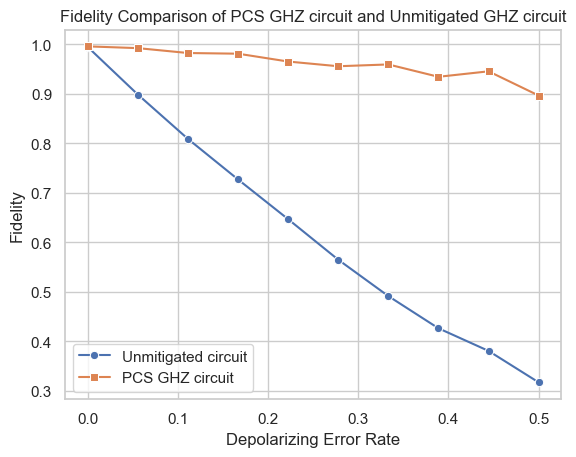

In [26]:
def plot_data(data):
    dep_errors, unmitigated, mitigated = data
    sns.set(style="whitegrid")
    sns.lineplot(x=dep_errors, y=unmitigated,
                label="Unmitigated circuit", marker="o")
    sns.lineplot(x=dep_errors, y=mitigated,
                label="PCS GHZ circuit", marker="s")

    plt.title("Fidelity Comparison of PCS GHZ circuit and Unmitigated GHZ circuit")
    plt.xlabel("Depolarizing Error Rate")
    plt.ylabel("Fidelity") 
    plt.legend()
    plt.show()

plot_data(experiment_data(dim=10))


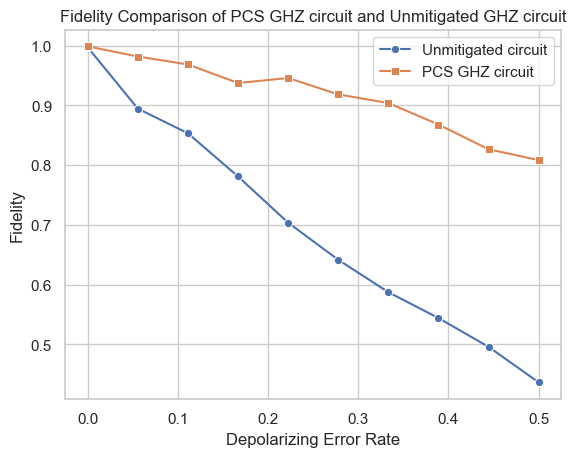

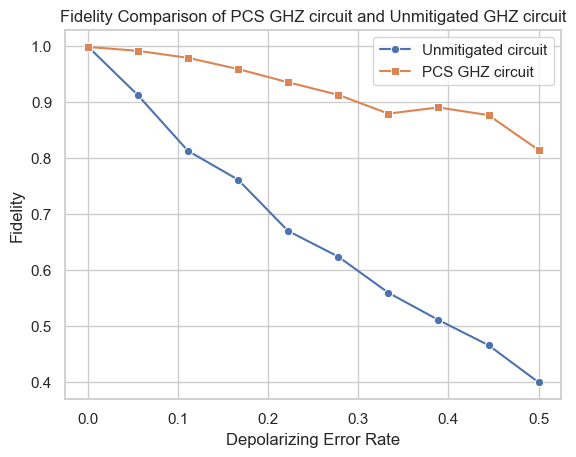

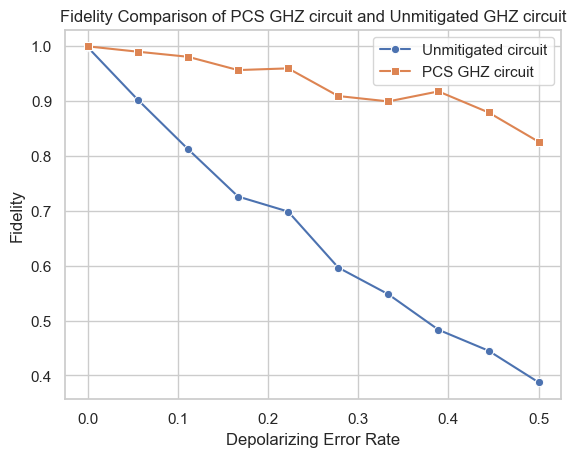

In [27]:
for d in range(3,6):
    plot_data(experiment_data(dim=d))

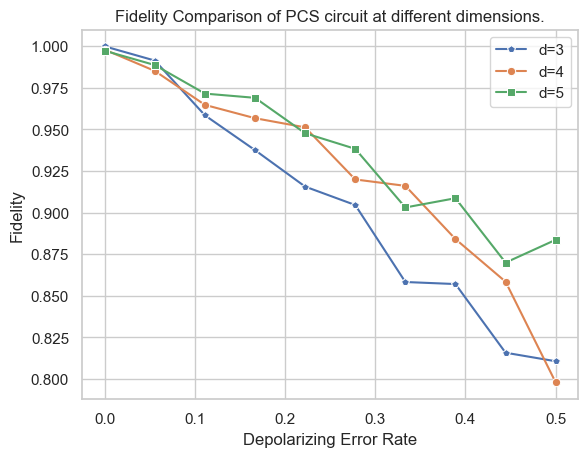

In [ ]:
def dimension_data():
    dimension_fidelities = []
    for d in range(3,6):
        error_rates = []
        mitigated_fidelities = []
        for p in np.linspace(0,0.5,10):
            results = sim_dep_error_rates(d,p)
            error_rates.append(results[0])
            # unmitigated_fidelities.append(results[1])
            mitigated_fidelities.append(results[2])
        dimension_fidelities.append(mitigated_fidelities)
    return error_rates, dimension_fidelities

def plot_data(data):
    dep_errors, mitigated_data = data
    dim3,dim4,dim5 = mitigated_data
    sns.set(style="whitegrid")
    sns.lineplot(x=dep_errors,y=dim3, label="d=3",marker="p")
    sns.lineplot(x=dep_errors, y=dim4,
                label="d=4", marker="o")
    sns.lineplot(x=dep_errors, y=dim5,
                label="d=5", marker="s")

    plt.title("Fidelity Comparison of PCS GHZ circuit at different dimensions.")
    plt.xlabel("Depolarizing Error Rate")
    plt.ylabel("Fidelity")
    plt.legend()
    plt.show()


plot_data(dimension_data())